In [107]:
#Import libraries

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import models
import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from IPython.display import Image # it will allow us to render the images in notebook

In [108]:
#Downloading Fashion MNIST Dataset
train_list_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #DctBlurry(threshold=5),
    ])

test_list_transforms = transforms.Compose([
        transforms.ToTensor(),
    ])

fashion_mnist_train = dsets.FashionMNIST(root='./data1/',
                          train=True,
                          transform=train_list_transforms,
                          download=True)

fashion_mnist_aux = dsets.FashionMNIST(root='./data1/',
                         train=False,
                         transform=test_list_transforms,
                         download=True)

fashion_mnist_test, fashion_mnist_valid = torch.utils.data.random_split(fashion_mnist_aux, [5000, 5000], generator=torch.Generator().manual_seed(42))

In [109]:
#Initialize DataLoader

batch_size = 128
torch.manual_seed(0)
n_workers = 5

train_loader  = torch.utils.data.DataLoader(dataset=fashion_mnist_train,
                                           batch_size=batch_size,
                                           shuffle=42, num_workers=n_workers)

test_loader = torch.utils.data.DataLoader(dataset=fashion_mnist_test,
                                         batch_size=batch_size,
                                         shuffle=42, num_workers=n_workers)

valid_loader = torch.utils.data.DataLoader(dataset=fashion_mnist_valid,
                                         batch_size=batch_size,
                                         shuffle=42, num_workers=n_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [110]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
images = example_data[0:len(example_data)] # this is just for original data

In [111]:
# Log Tranformation for Gray Scale images
def log_transformation(example_data,example_targets):
  img_data = example_data
  img_targets = example_targets
  log_transformed_dataset = []

  for i in range(len(img_data)):
    image = img_data[i,0].numpy() # converted into 2d numpy array
    # Apply log transformation method
    c = 255 / np.log(1 + np.max(image))
    log_image = c * (np.log(image + 1))
      
    # Specify the data type so that
    # float value will be converted to int
    log_image = np.array(log_image, dtype = np.uint8)
    log_transformed_dataset.append(log_image)
  return torch.as_tensor(log_transformed_dataset) ,img_targets # list converted to tensor and returned, we can also return targets if it is needed 

lt_test_data,lt_test_target = log_transformation(example_data,example_targets)


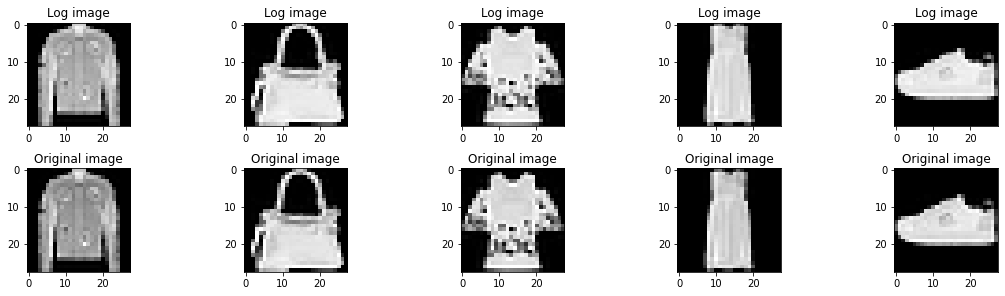

In [112]:
num_images = 5
org_images = example_data[0:num_images] # Images without transformation

fig, ax = plt.subplots(2, num_images,constrained_layout=True, figsize=(15, 4))

for i in range(num_images):
    ax[0][i].imshow(lt_test_data[i], cmap='gray', interpolation='none')
    ax[0][i].set_title(f'Log image')
    ax[1][i].imshow(images[i,0], cmap='gray', interpolation='none')
    ax[1][i].set_title(f'Original image')


In [113]:
print("LT TEST LABELS")
print(lt_test_target)
print("ORG TEST LABELS")
print(example_targets)

LT TEST LABELS
tensor([4, 8, 6, 3, 7, 1, 2, 2, 4, 8, 9, 2, 4, 7, 3, 3, 7, 3, 8, 4, 5, 4, 0, 1,
        7, 2, 1, 3, 9, 4, 3, 0, 8, 8, 4, 8, 5, 1, 4, 2, 8, 5, 3, 6, 4, 4, 7, 3,
        5, 5, 4, 7, 1, 5, 0, 5, 6, 9, 3, 1, 1, 7, 9, 9, 9, 1, 1, 5, 4, 3, 5, 8,
        9, 4, 0, 0, 6, 3, 8, 4, 6, 9, 2, 4, 3, 8, 6, 0, 5, 4, 8, 7, 3, 0, 4, 2,
        4, 5, 8, 9, 8, 6, 4, 3, 0, 8, 4, 7, 5, 6, 4, 3, 9, 5, 4, 4, 7, 8, 7, 8,
        4, 1, 2, 3, 5, 7, 2, 8])
ORG TEST LABELS
tensor([4, 8, 6, 3, 7, 1, 2, 2, 4, 8, 9, 2, 4, 7, 3, 3, 7, 3, 8, 4, 5, 4, 0, 1,
        7, 2, 1, 3, 9, 4, 3, 0, 8, 8, 4, 8, 5, 1, 4, 2, 8, 5, 3, 6, 4, 4, 7, 3,
        5, 5, 4, 7, 1, 5, 0, 5, 6, 9, 3, 1, 1, 7, 9, 9, 9, 1, 1, 5, 4, 3, 5, 8,
        9, 4, 0, 0, 6, 3, 8, 4, 6, 9, 2, 4, 3, 8, 6, 0, 5, 4, 8, 7, 3, 0, 4, 2,
        4, 5, 8, 9, 8, 6, 4, 3, 0, 8, 4, 7, 5, 6, 4, 3, 9, 5, 4, 4, 7, 8, 7, 8,
        4, 1, 2, 3, 5, 7, 2, 8])


CIFAR10 DATASET

In [114]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

#Downloading CIFAR-10 Dataset
cifar10_train = CIFAR10(root='data2/', train=True,download=True, transform=ToTensor())
cifar10_aux = CIFAR10(root ='data2/',train=False,transform=ToTensor())
cifar10_test, cifar10_valid = torch.utils.data.random_split(cifar10_aux, [5000, 5000], generator=torch.Generator().manual_seed(42))



Files already downloaded and verified


In [115]:
#Initialize DataLoader

batch_size = 128
torch.manual_seed(0)
n_workers = 5

train_loader_CIFAR10  = torch.utils.data.DataLoader(dataset=cifar10_train,
                                           batch_size=batch_size,
                                           shuffle=42, num_workers=n_workers)

test_loader_CIFAR10 = torch.utils.data.DataLoader(dataset=cifar10_test,
                                         batch_size=batch_size,
                                         shuffle=42, num_workers=n_workers)

valid_loader_CIFAR10 = torch.utils.data.DataLoader(dataset=cifar10_valid,
                                         batch_size=batch_size,
                                         shuffle=42, num_workers=n_workers)

images.shape: torch.Size([128, 3, 32, 32])


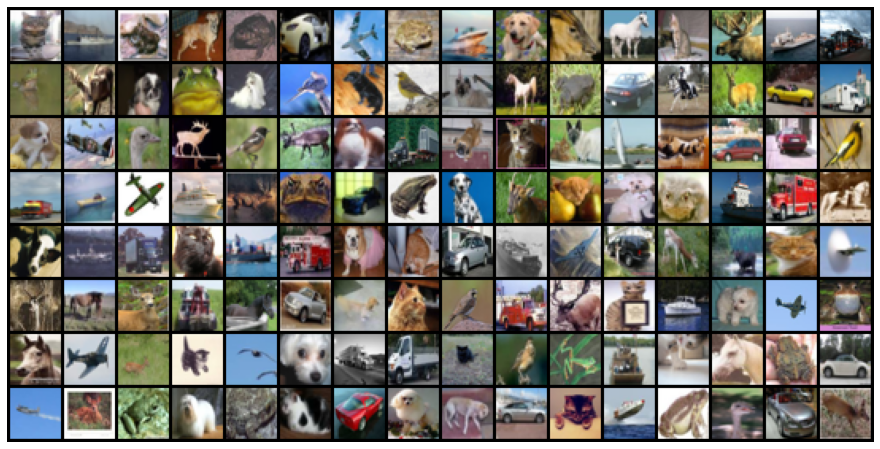

In [116]:
for images, _ in test_loader_CIFAR10:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [117]:
examples = enumerate(test_loader_CIFAR10)
batch_idx, (example_data_cifar10, example_targets_cifar10) = next(examples)
images = example_data_cifar10[0:len(example_data_cifar10)] # this is just for original data

In [118]:
#For RGB images we can use HSI  which is I = (R+B+G) / 3
#cv2.split() divides a multi-channel array into several single-channel arrays
#cv2.merge() merges several arrays to make a single multi-channel array. All the input matrices must have the same size



Text(0.5, 1.0, 'BGR Output')

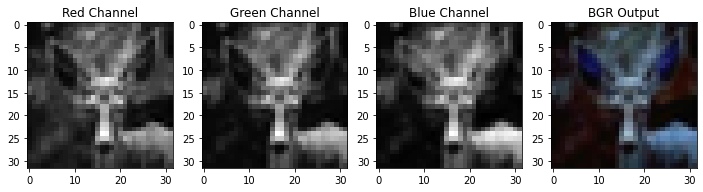

In [128]:
#Split the image into the B,G,R components
b, g, r    = example_data_cifar10[0][0,:, :],  example_data_cifar10[0][1,:, :],  example_data_cifar10[0][2,:, :] # For RGB image
#Show the channels
plt.figure(figsize=[12,8])
plt.subplot(141);plt.imshow(r,cmap="gray");plt.title("Red Channel")
plt.subplot(142);plt.imshow(g,cmap="gray");plt.title("Green Channel")
plt.subplot(143);plt.imshow(b,cmap="gray");plt.title("Blue Channel")


#Merge the individual channels into a BGR image
#Show the merged output
bgr = np.dstack((b,g,r))
torch.as_tensor(bgr)
plt.subplot(144);plt.imshow(bgr[:,:,::-1]);plt.title("BGR Output") # opencv reads RGB images as BGR so if we want to see as bgr we have to read from end



In [121]:
def rgb_to_bgr(example_data_cifar10, example_targets_cifar10):
  b_ = [];g_ = [];r_ = [];bgr = []

  for i in range(len(example_data_cifar10)):
    b_.append(example_data_cifar10[i][0,:, :])
    g_.append(example_data_cifar10[i][1,:, :])
    r_.append(example_data_cifar10[i][2,:, :]) # For RGB image
    bgr_ = np.dstack((b_[i],g_[i],r_[i]))
    bgr.append(bgr_)
  return torch.as_tensor(bgr),example_targets_cifar10


bgr_cifar10,targets_10 = rgb_to_bgr(example_data_cifar10, example_targets_cifar10)

bgr_cifar10.shape

torch.Size([128, 32, 32, 3])

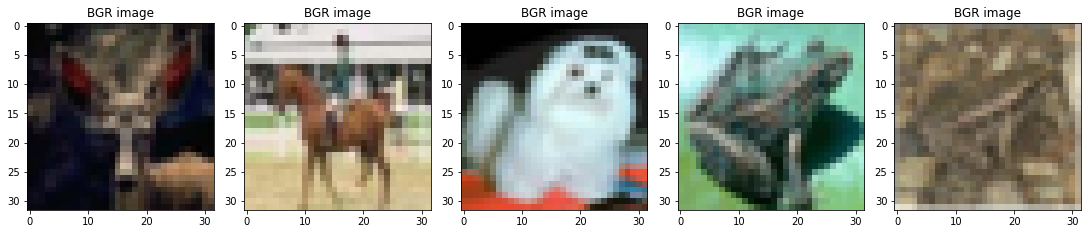

In [122]:
num_images = 5

fig, ax = plt.subplots(1, num_images,constrained_layout=True, figsize=(15, 4))

for i in range(num_images):
    ax[i].imshow(bgr_cifar10[i], interpolation='none')
    ax[i].set_title(f'BGR image')  # opencv reads RGB images as BGR so if we want to see as bgr we have to read from end


In [123]:
#HSI representation space for RGB images i am not sure we can apply to gray scale

def rgb_to_hsi(example_data_cifar10, example_targets_cifar10):
  b_ = [];g_ = [];r_ = [];hsi = []

  for i in range(len(example_data_cifar10)):
    b_.append(example_data_cifar10[i][0,:, :] / 3)
    g_.append(example_data_cifar10[i][1,:, :]/3)
    r_.append(example_data_cifar10[i][2,:, :]/3) # For RGB image
    hsi_ = np.dstack((b_[i],g_[i],r_[i]))
    hsi.append(hsi_)
  return torch.as_tensor(hsi),example_targets_cifar10


hsi_cifar10,targets_10 = rgb_to_hsi(example_data_cifar10, example_targets_cifar10)



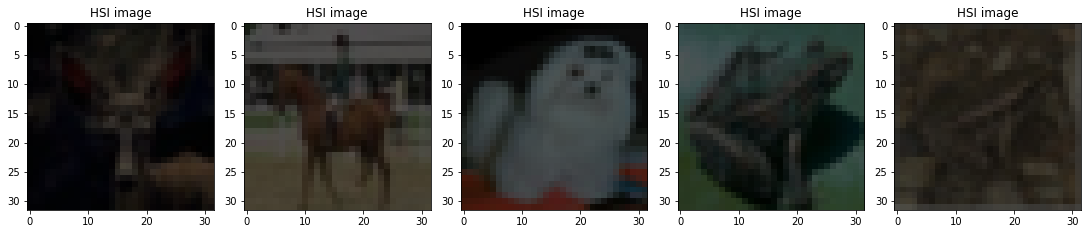

In [124]:
num_images = 5

fig, ax = plt.subplots(1, num_images,constrained_layout=True, figsize=(15, 4))

for i in range(num_images):
    ax[i].imshow(hsi_cifar10[i], interpolation='none')
    ax[i].set_title(f'HSI image')  # opencv reads RGB images as BGR so if we want to see as bgr we have to read from end
